The number of MSOAs is: 7264
88928.0
27671935.0
Dominant Eigenvalue: 6224.1935712712875


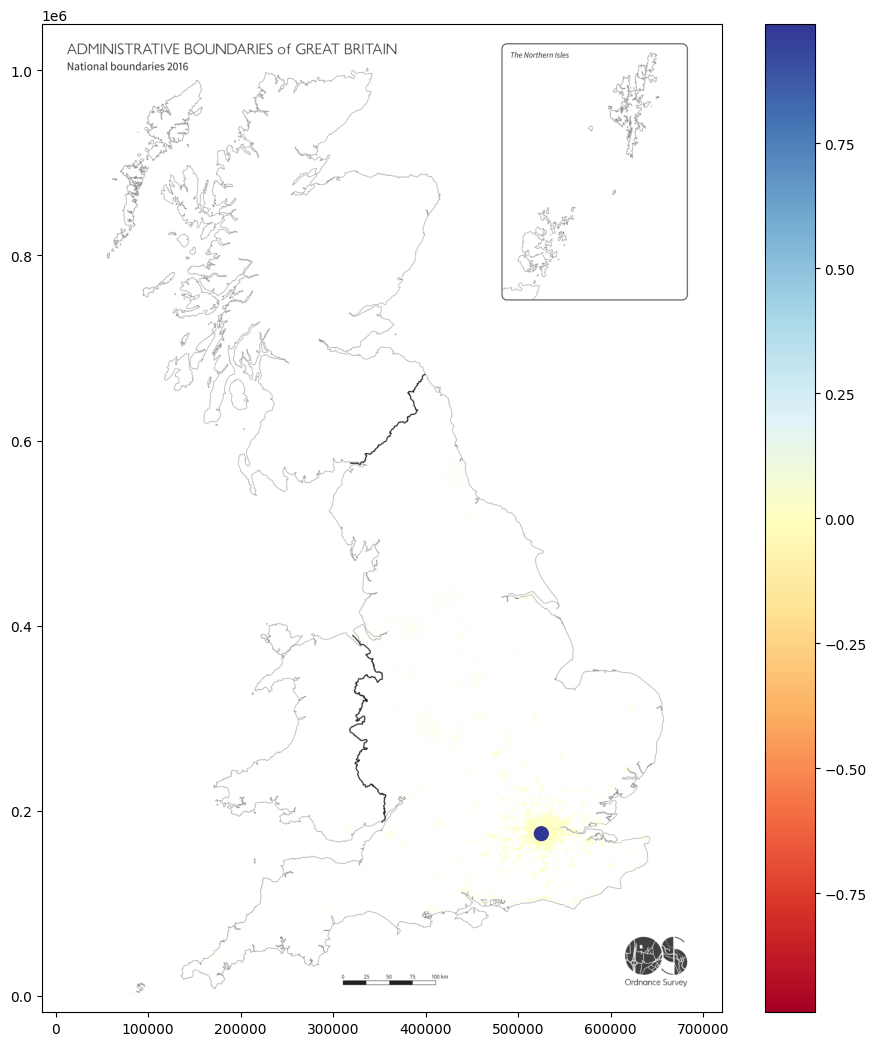

[8.09240580e-04 4.14970406e-04 9.13095667e-04 ... 6.91913667e-06
 1.04219046e-05 1.23334090e-05]

6224.1935712712875
Eigenvector 1 eigenvalue: 12685.685686050983


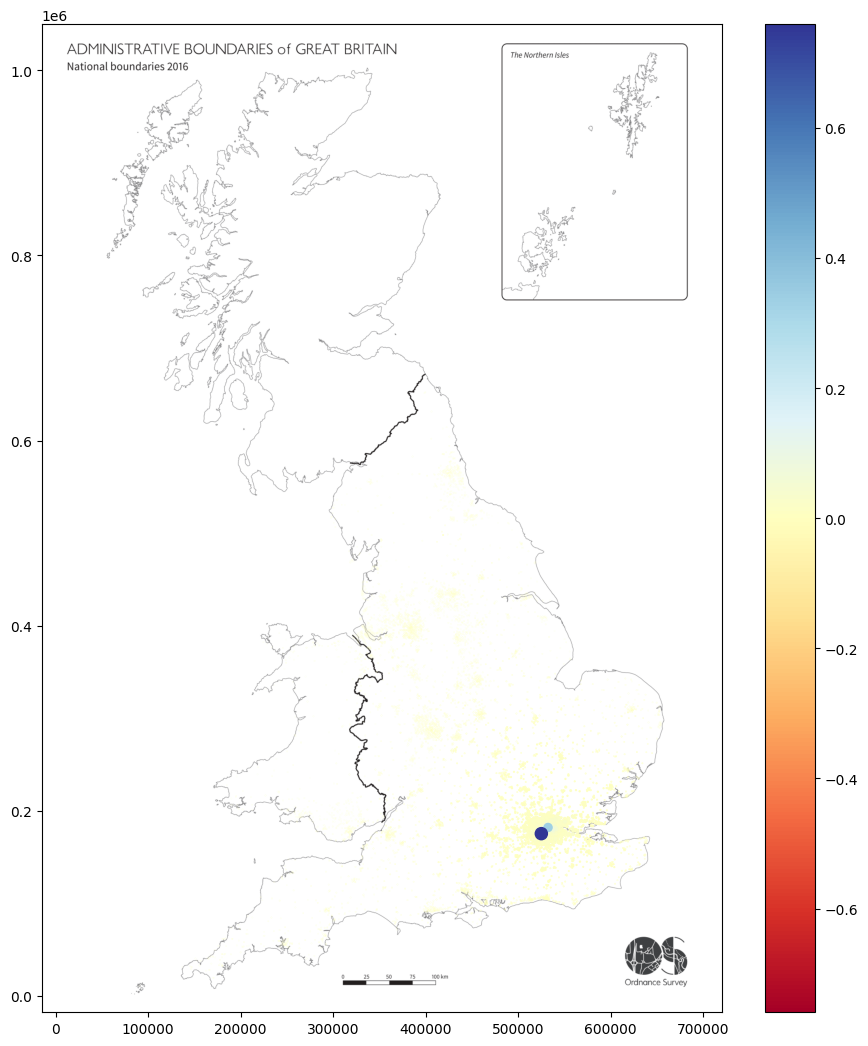

Eigenvector 2 eigenvalue: 12133.374389476163


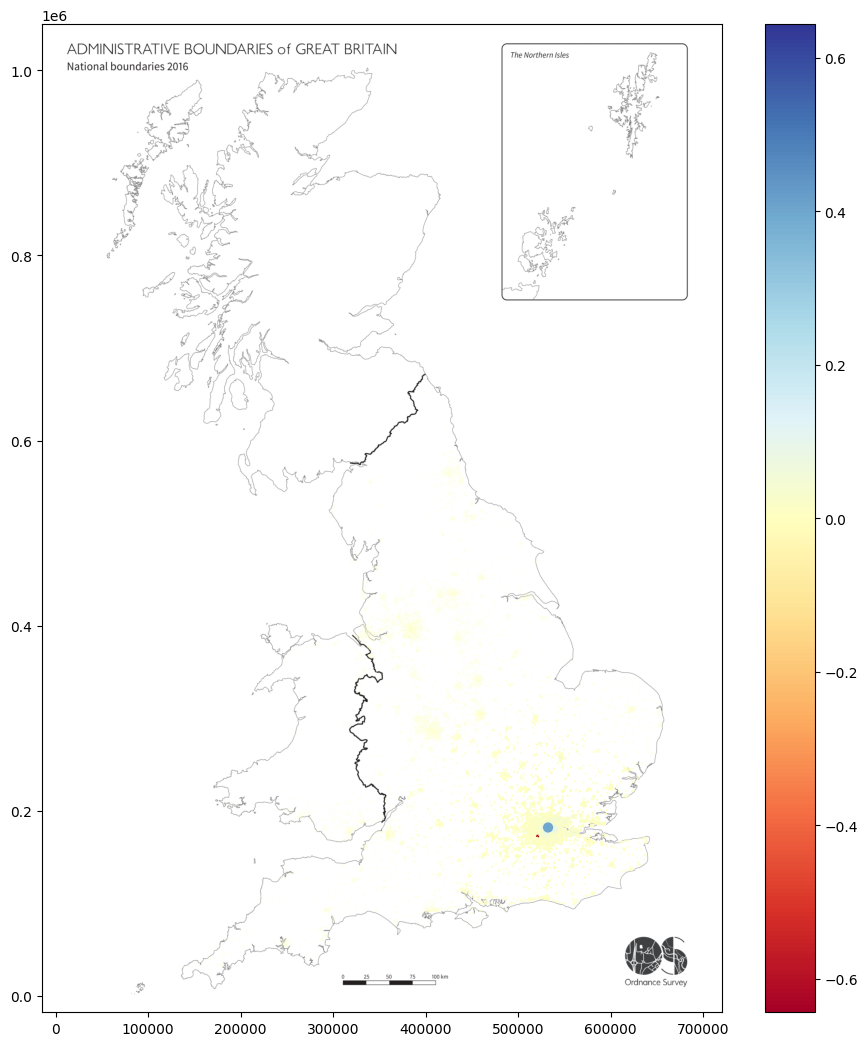

Eigenvector 3 eigenvalue: 11309.05357668185


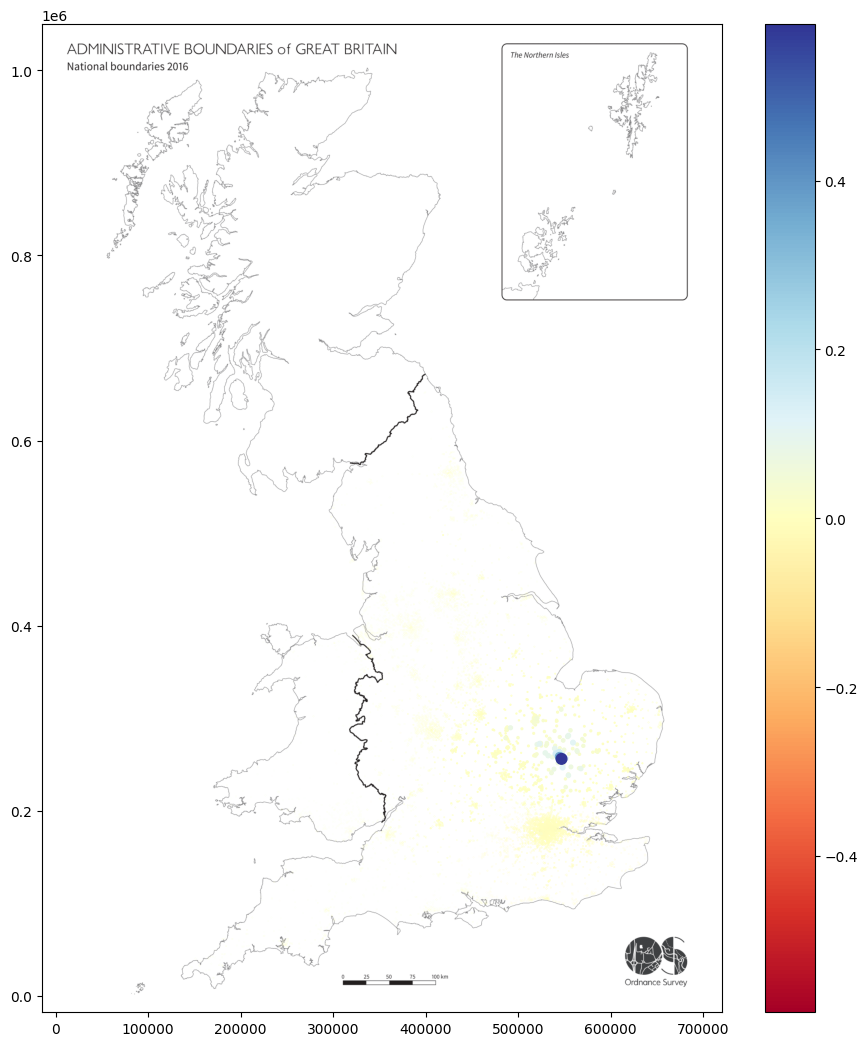

Eigenvector 4 eigenvalue: 10992.945014258836


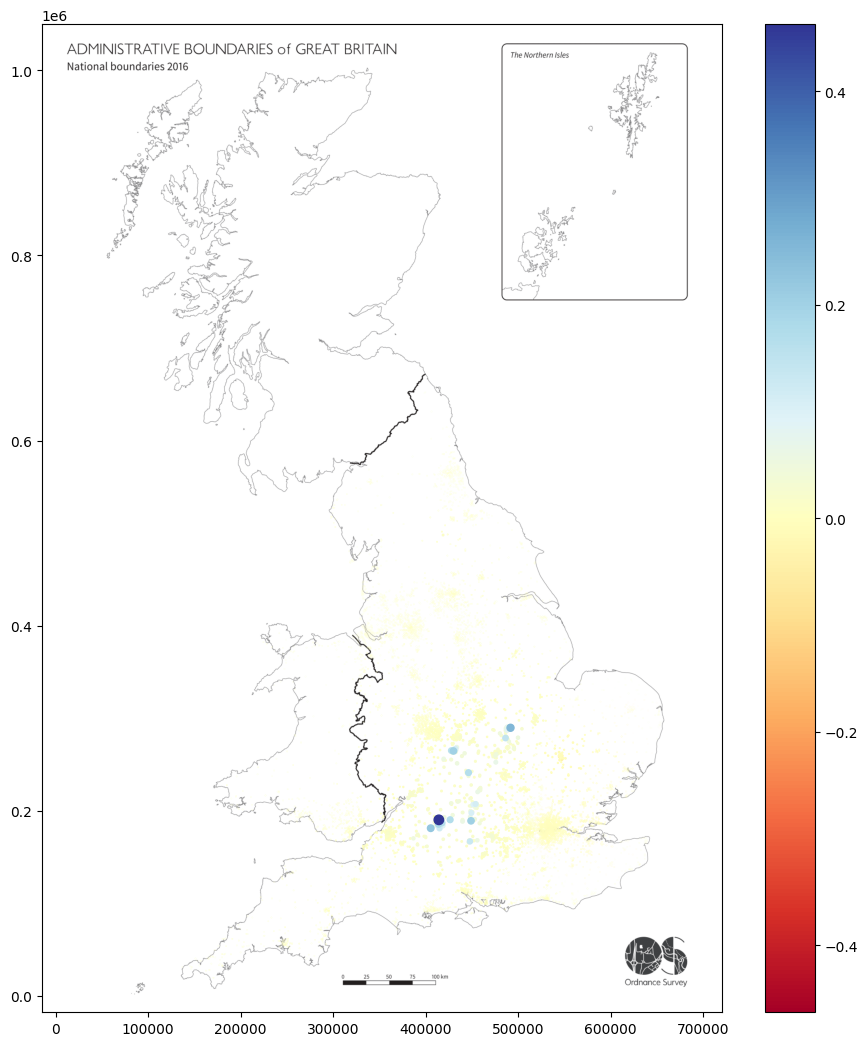

Eigenvector 5 eigenvalue: 10946.422465027666


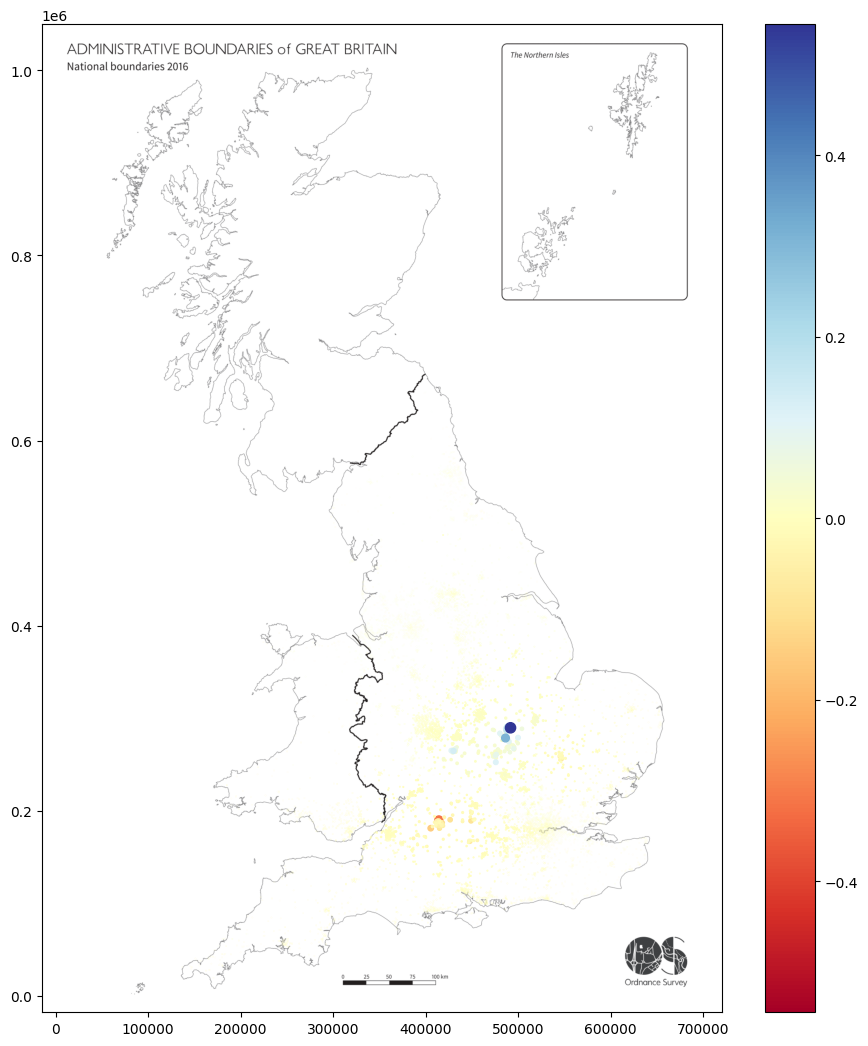

Eigenvector 6 eigenvalue: 10861.271045553356


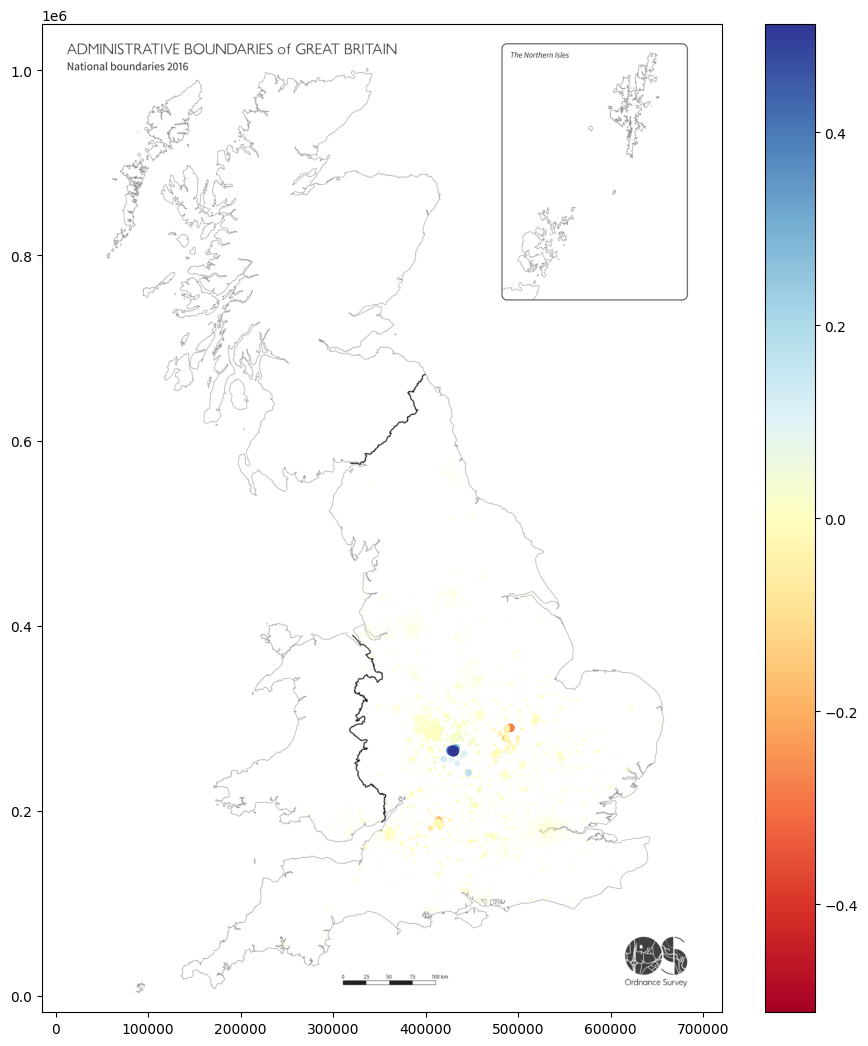

Eigenvector 7 eigenvalue: 10561.945990983066


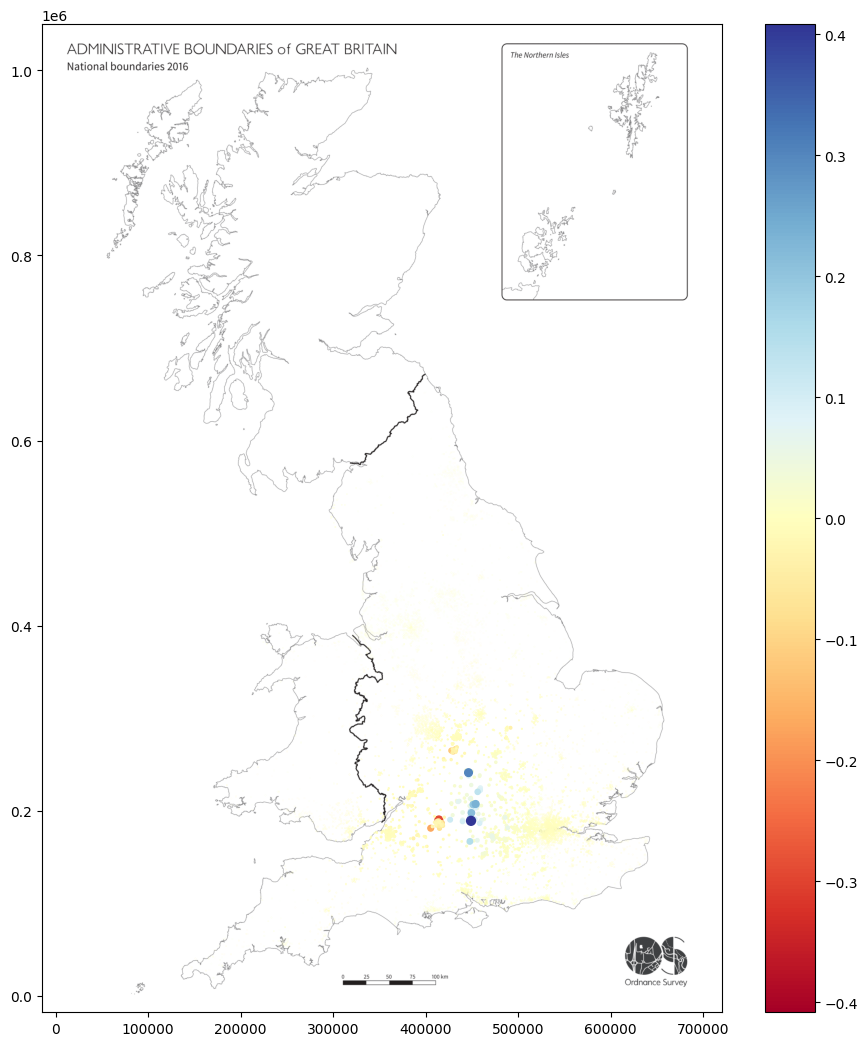

Eigenvector 8 eigenvalue: 10463.832218652311


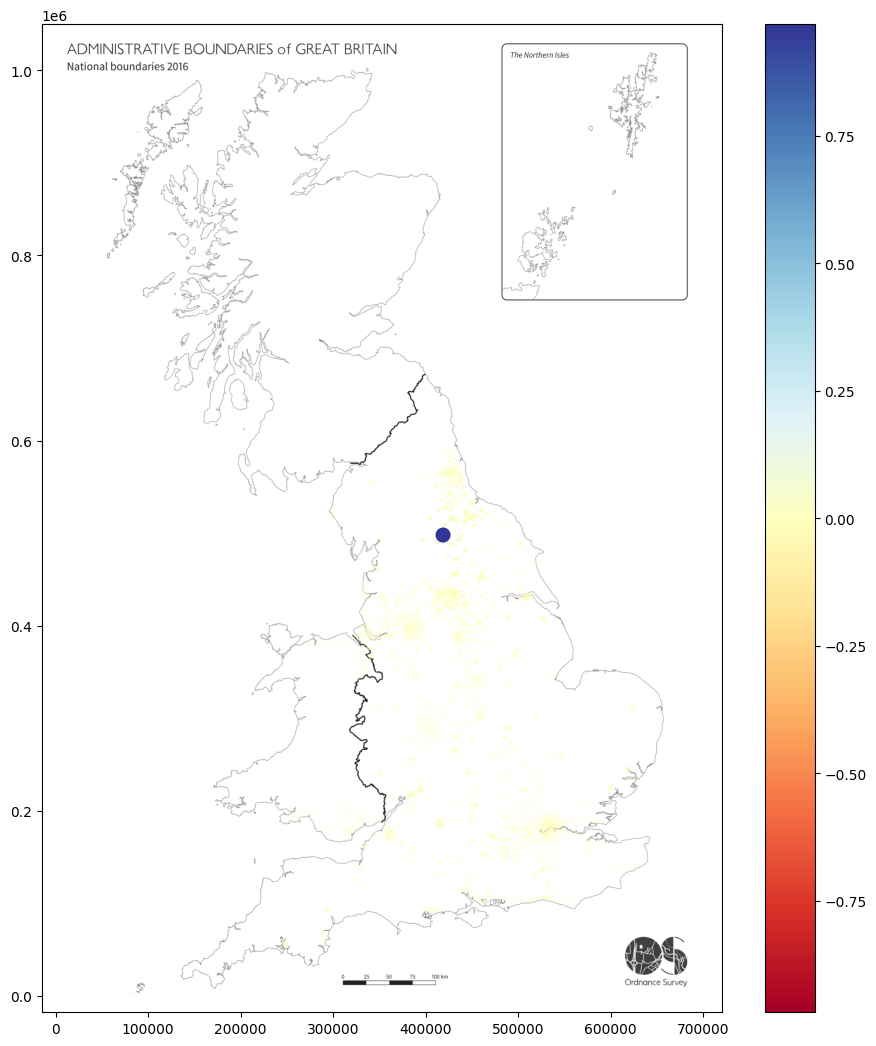

Eigenvector 9 eigenvalue: 10369.465202400932


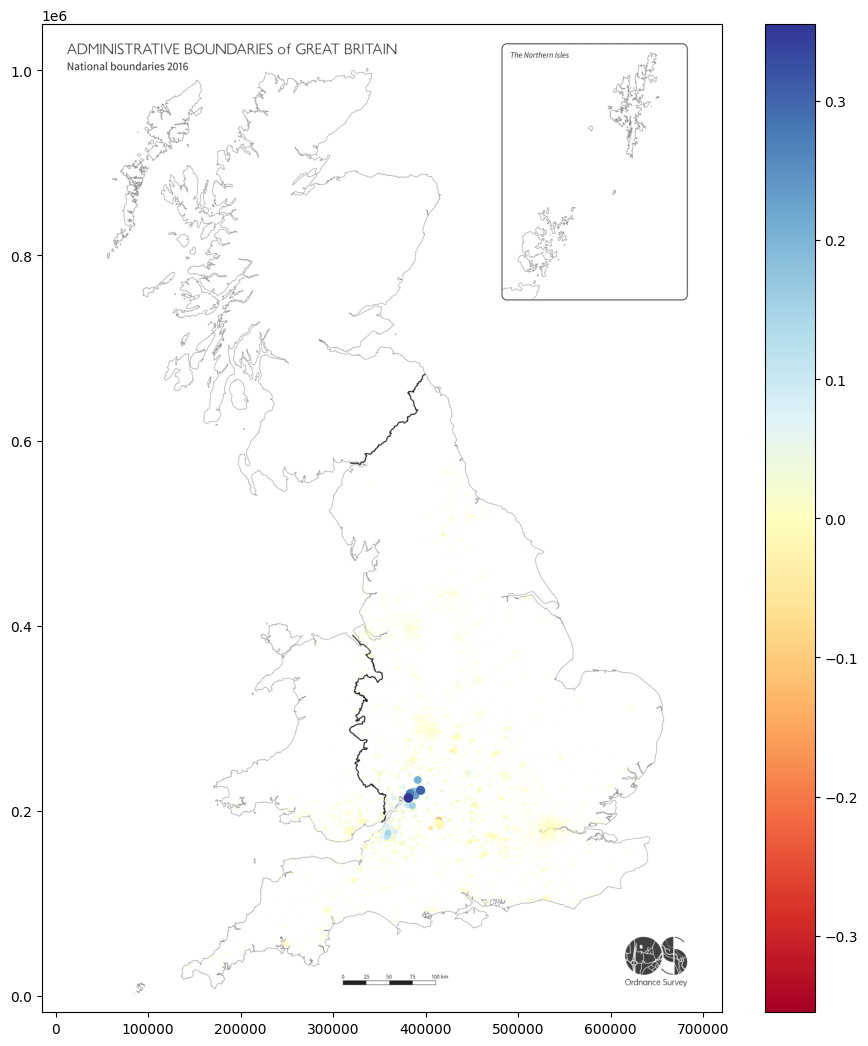

Eigenvector 10 eigenvalue: 10278.994682779743


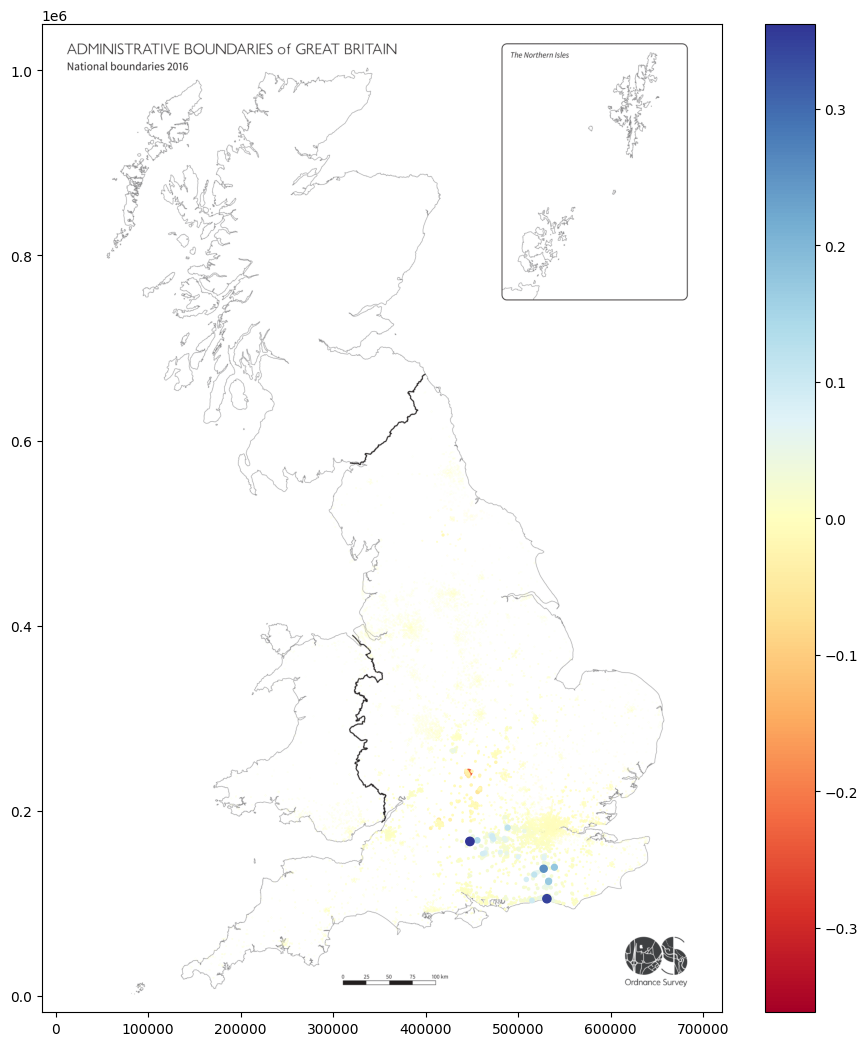

XtX Eigenvector 1 eigenvalue: 43826108.94874596


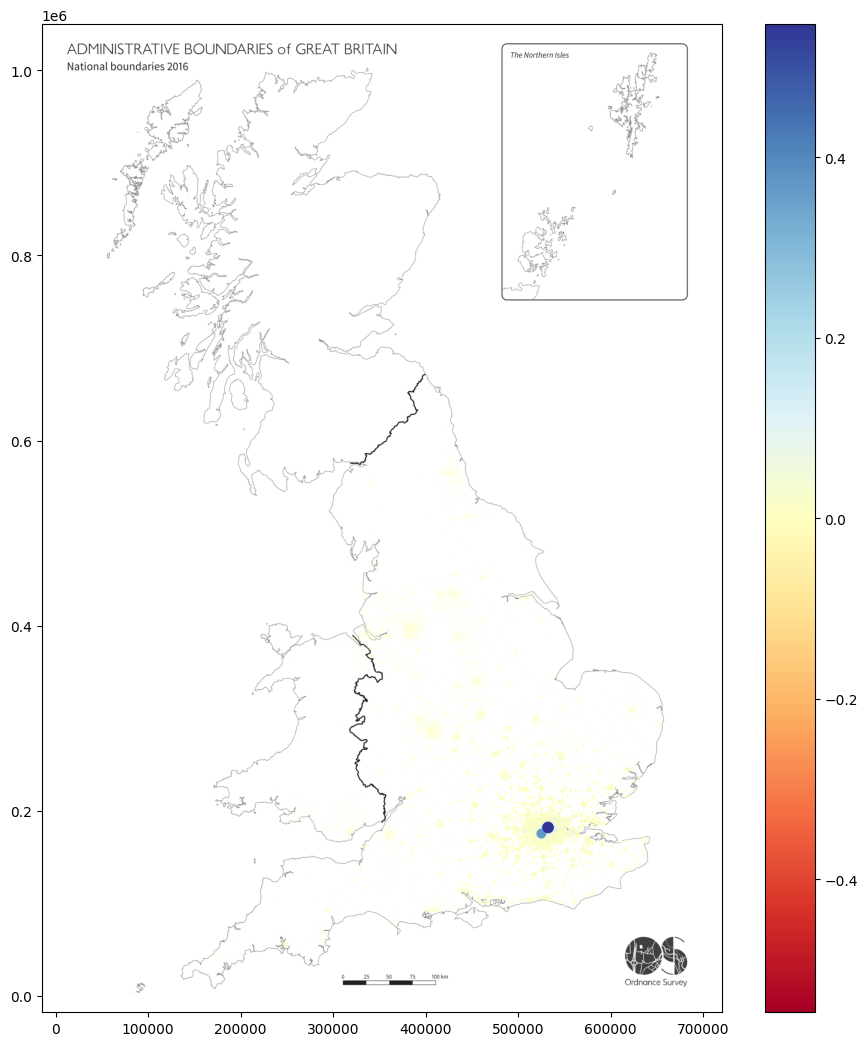

XtX Eigenvector 2 eigenvalue: 38043858.28594552


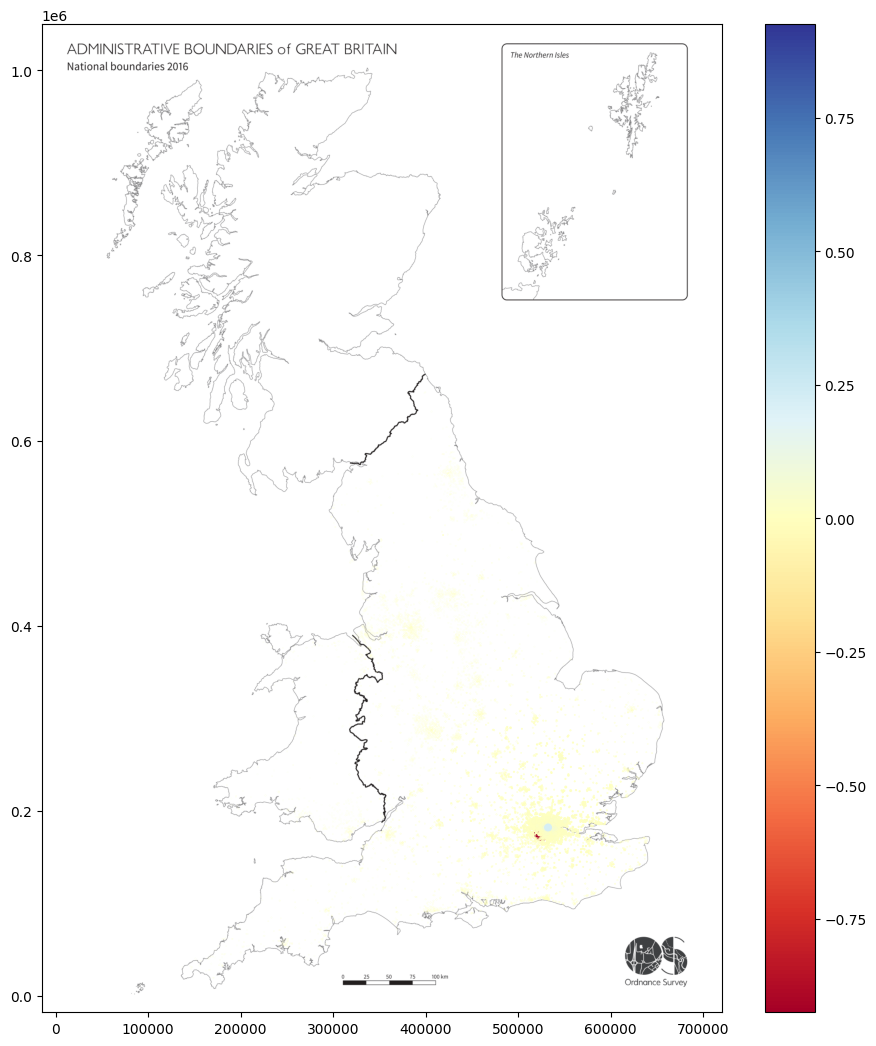

XtX Eigenvector 3 eigenvalue: 34831987.05570409


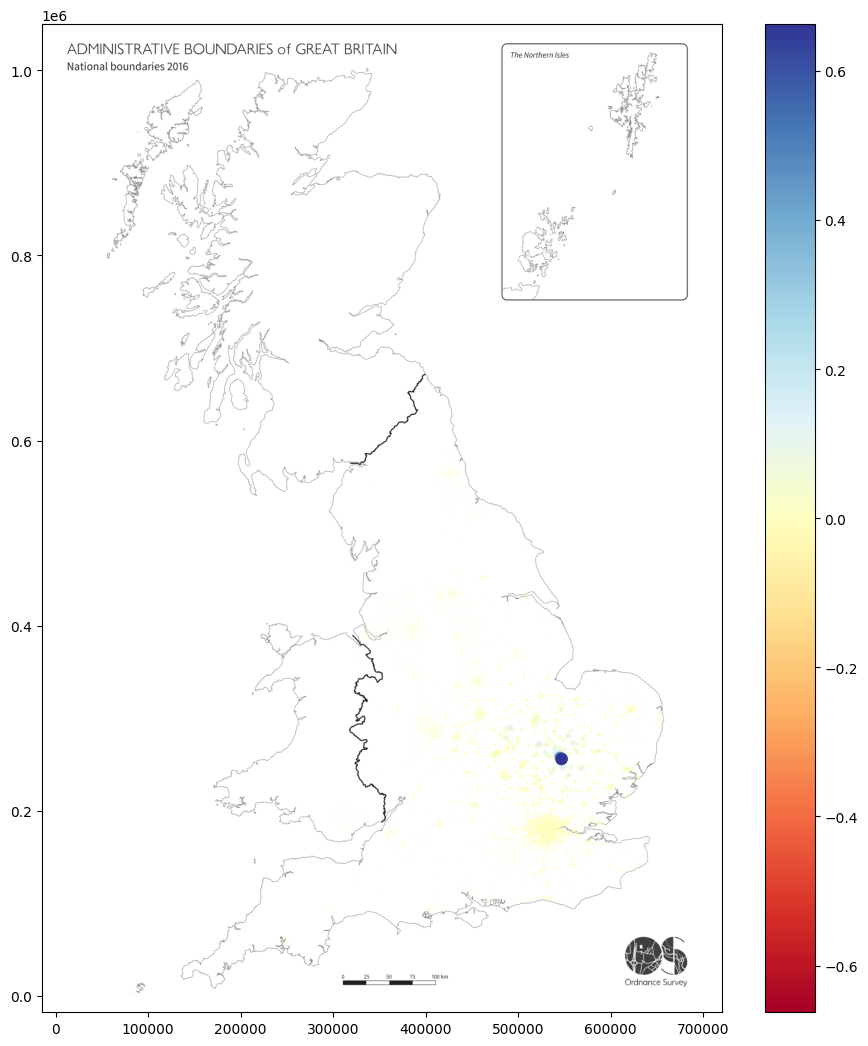

XtX Eigenvector 4 eigenvalue: 33303160.988059457


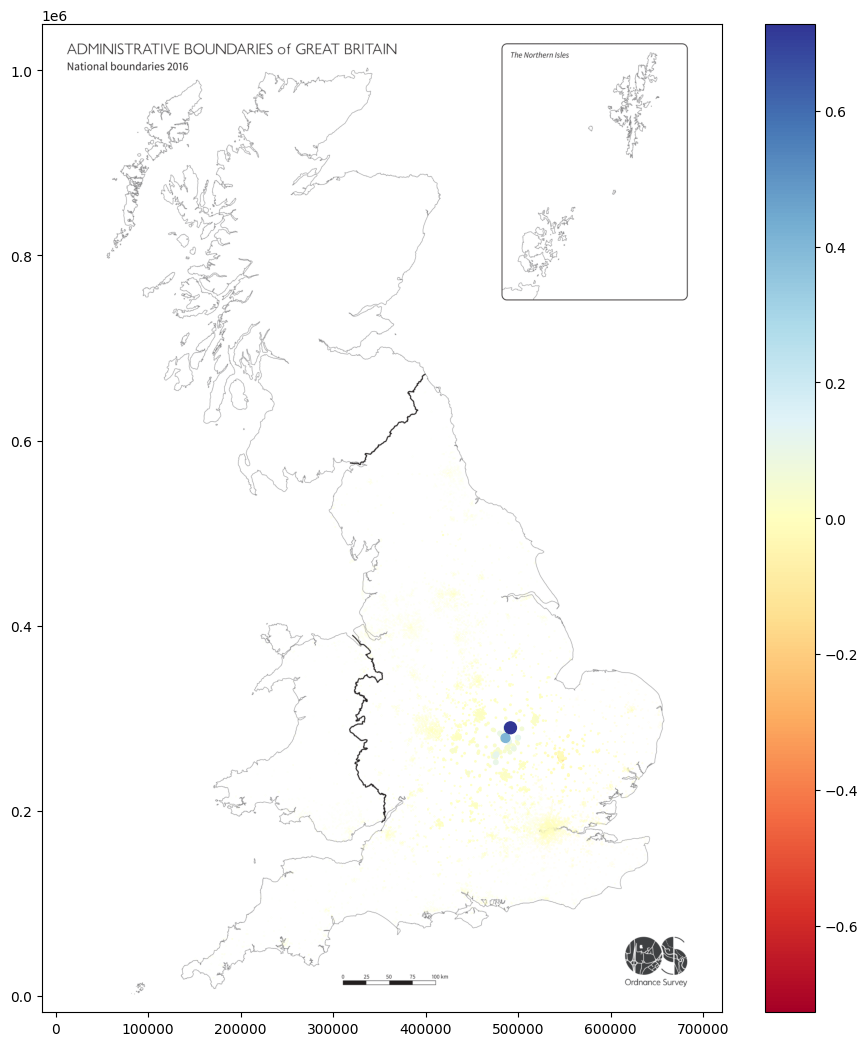

XtX Eigenvector 5 eigenvalue: 31601940.500863113


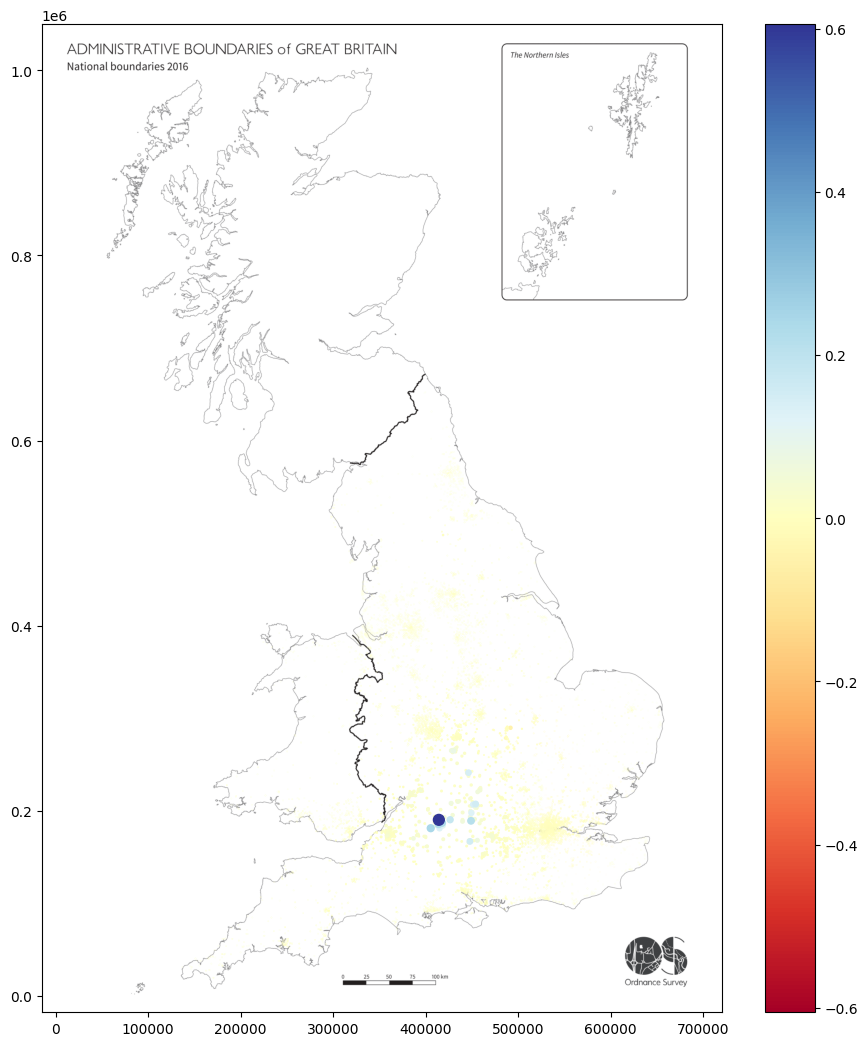

XXt Eigenvector 1 eigenvalue: 43826108.94871645


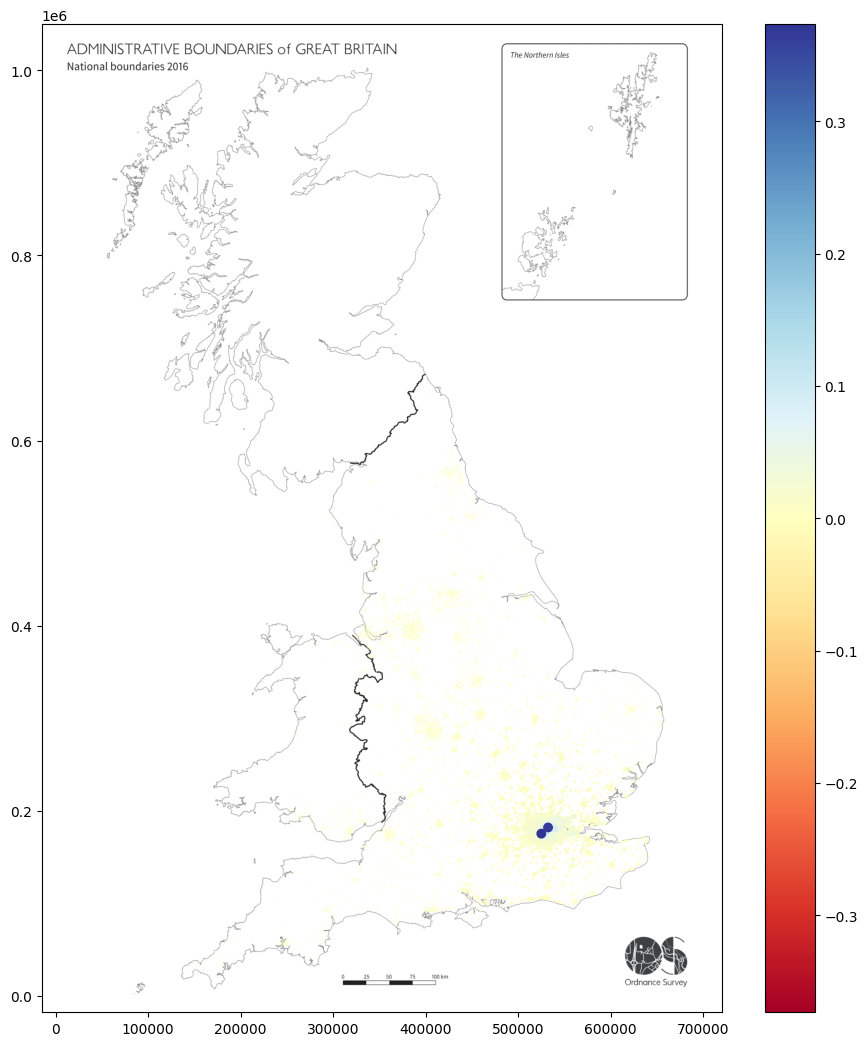

XXt Eigenvector 2 eigenvalue: 38043858.28599516


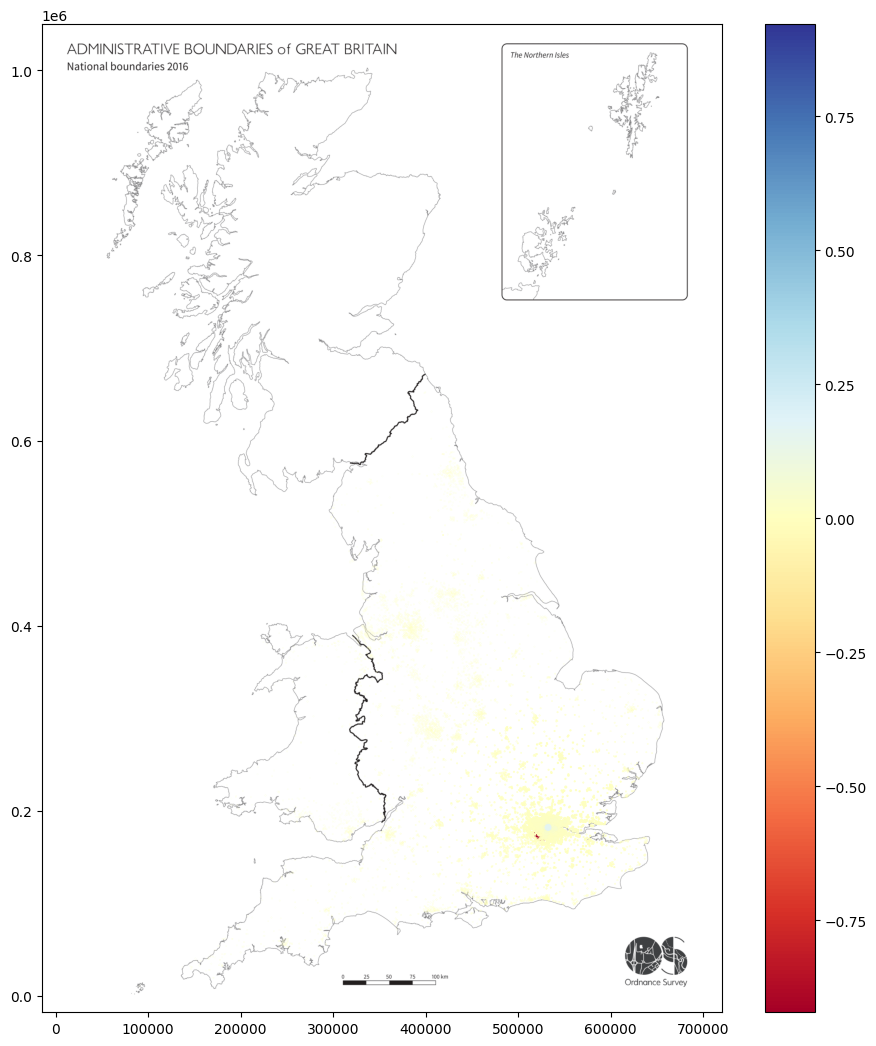

XXt Eigenvector 3 eigenvalue: 34831987.05569734


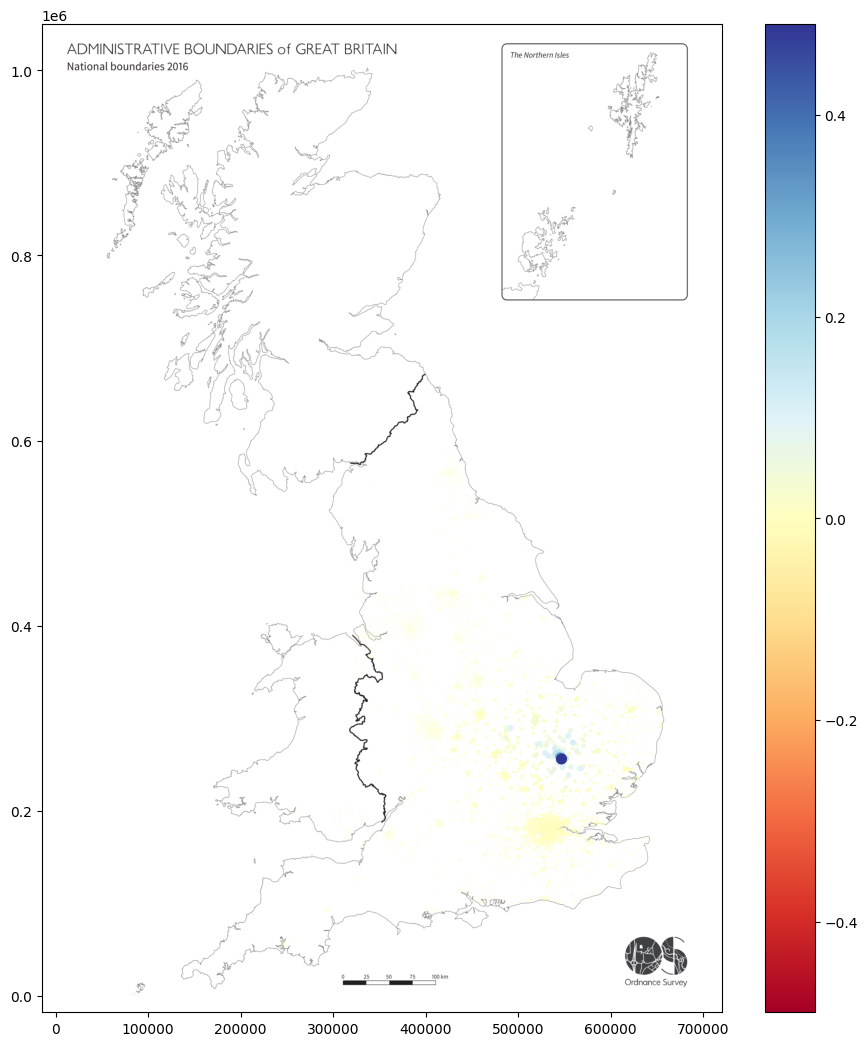

XXt Eigenvector 4 eigenvalue: 33303160.988083616


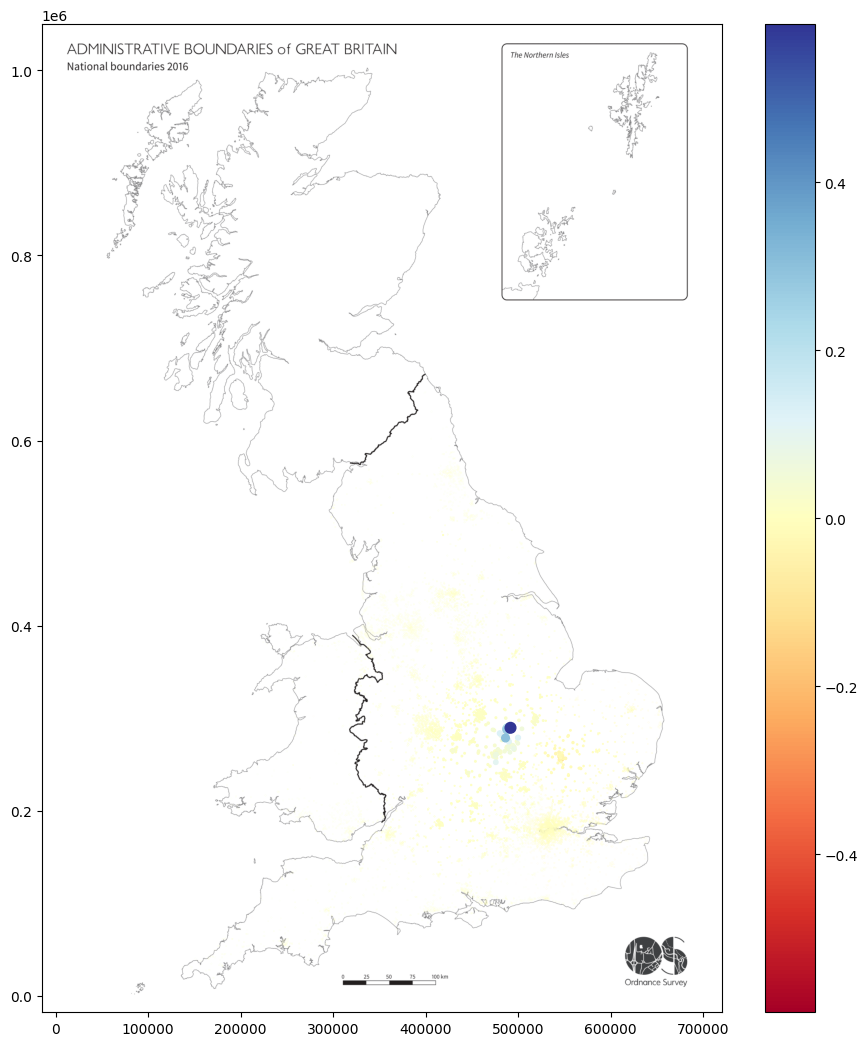

XXt Eigenvector 5 eigenvalue: 31601940.500812814


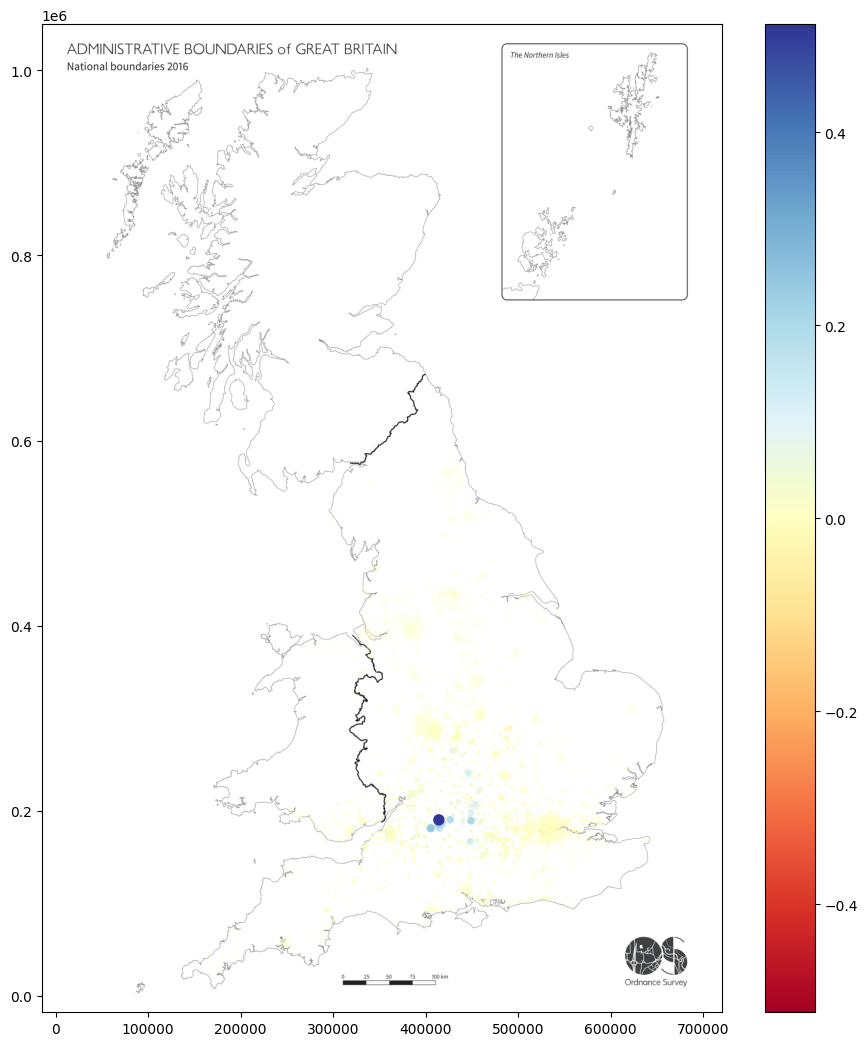

Eigenvalues of XtX:
[43826108.94874596, 38043858.28594552, 34831987.05570409, 33303160.988059457, 31601940.500863113]

Eigenvalues of XXt:
[43826108.94871645, 38043858.28599516, 34831987.05569734, 33303160.988083616, 31601940.500812814]
Difference in eigenvalue 1: 0.00003
Difference in eigenvalue 2: 0.00005
Difference in eigenvalue 3: 0.00001
Difference in eigenvalue 4: 0.00002
Difference in eigenvalue 5: 0.00005


In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## This loads travel_matrix

travel_matrix = np.load('ODWP_matrix.npy')



## This line imports the basic coordinates of each MSOA
(x_coords,y_coords) = np.load('coords.npy')


## Count the number of Mid-level Super Output Areas (MSOAs)
## Using this variable to avoid hardwiring 7264 in your code so if the travel matrix gets new MSOAs it will also change 
msoa_count, _ = travel_matrix.shape

# Initialising  the plotting parameters and scaling the figure size so plot isnt to big or small
x_diff = max(x_coords) - min(x_coords) #width of coordinate domain
y_diff = max(y_coords) - min(y_coords) #height of coordinate domain
plt.rcParams["figure.figsize"] = (0.00002*x_diff, 0.00002*y_diff)

## This code defines the plot_MSOA_vec function that draws maps

def plot_MSOA_vec(vec, cm='RdYlBu'):
    """
    Plot a vector with support in MSOAs.This should be a unit vector.
    Size of a point and colour represents strength of support 
    """
    img = plt.imread("uk-1.png")
    fig, ax = plt.subplots()
    ax.imshow(img,extent=[-15000, 720000, -18000, 1050000])
    cm = matplotlib.colormaps[cm]
    coord_df=pd.DataFrame([x_coords, y_coords, vec]).T.sort_values(2, ascending=True)
    coord_df.columns=['x_coord', 'y_coord', 'vec']
    sc = plt.scatter(coord_df.x_coord, 
                     coord_df.y_coord, 
                     c=((coord_df.vec)), 
                     s=100*abs(coord_df.vec),
                     vmin = -max(abs(coord_df.vec)), 
                     vmax = max(abs(coord_df.vec)), 
                     cmap=cm)
    plt.colorbar(sc)
    plt.show()  


print(f"The number of MSOAs is: {msoa_count}")


column_index = 0 
column_sum = travel_matrix[:, column_index] #collects all rows in column 0
work_in_region0 = np.sum(column_sum) #Sums through the rows in column 0 

### Store the answer as work_in_region 0:
print(work_in_region0)


LA.norm(travel_matrix, ord=1) #Calculates the maximum absolute column sum which will give the largest destination


working_population = np.sum(travel_matrix) #Total number of commuters
print(working_population)


 
x = np.ones(msoa_count) # initializes a guess vector of all 1s 
x = x / LA.norm(x) # normalizes to get unit vector 

tolerance = 1e-6 # low tolerance to get good estimate and set convergence 
diff = 1 #initial error

iteration = 0

#This will apply the power iteration until the changes  are below tolerance so we can find the dominant eigenvector
while diff > tolerance:
    x_new = travel_matrix @ x #We matrix multiply travel matrix with x 
    
    
    x_new = x_new / LA.norm(x_new) #normalize so the values dont blow up or get too small
    diff = LA.norm(x_new - x) #calculates change 
    x = x_new # reset x to x_new so we can use that in next iteration
    iteration += 1

dominant_eigenvector = x #once loop breaks the changes in vectors are minimal and has likely converged thus giving us dominant eigenvalue 


dominant_eigenvalue = LA.norm(travel_matrix @ dominant_eigenvector) #Gives us dominant eigenvalue 

print("Dominant Eigenvalue:", dominant_eigenvalue)

plot_MSOA_vec(dominant_eigenvector) # highlights this dominant eigenvector on the map below



print(dominant_eigenvector)
print()
print(dominant_eigenvalue)

symmetric_travel = travel_matrix + travel_matrix.T #making sure out original matrix is symmetric by adding its transpose 
#this was to make sure the matrix would have real eigenvalues and eigenvectors can be orthogonal 


#This time we apply the Gram-Schmit(power method with projection) as we want to find more than one eigen pair 
def power_method_with_projection(A, prev_eigenvectors=[], tolerance=1e-6, max_iter=1000):
    
    x = np.random.rand(A.shape[0]) #random starting vector 
    

    for v in prev_eigenvectors:
        x = x - np.dot(x, v) * v #subtracts the projection from the previous eigenvectors 
        
    x = x / LA.norm(x) #normalizes 
    
    for _ in range(max_iter):
        x_new = A @ x
        for v in prev_eigenvectors:
            
            x_new = x_new - np.dot(x_new, v) * v #orthogonalize 
        x_new = x_new / LA.norm(x_new) #normalize 
        
        if LA.norm(x_new - x) < tolerance:
            break  #checks for convergence 
        x = x_new
        
        
    eigenvalue = np.dot(x.T, A @ x) #computes eigenvalue 
    return x, eigenvalue

# Find top 10 eigenvectors
top_eigenvectors = []

top_eigenvalues = []
#runs above method 10 times and plots onto map below
for i in range(10):
    vec, val = power_method_with_projection(symmetric_travel, top_eigenvectors)
    top_eigenvectors.append(vec)
    top_eigenvalues.append(val)
    
    print(f"Eigenvector {i+1} eigenvalue: {val}")
    plot_MSOA_vec(vec)


XtX = travel_matrix.T @ travel_matrix #creates symmetric  positive semi definite matrix to make computing eigenpairs much easier 
#This will look at similarities of destinations between commuters
xtx_eigenvectors = []

xtx_eigenvalues = []
#This for loop will reveal clusters based off where people travel to work (destinations)
for i in range(5):
    vec, val = power_method_with_projection(XtX, xtx_eigenvectors)
    xtx_eigenvectors.append(vec)
    
    xtx_eigenvalues.append(val)
    
    
    print(f"XtX Eigenvector {i+1} eigenvalue: {val}")
    
    plot_MSOA_vec(vec)

    

XXt = travel_matrix @ travel_matrix.T #Same idea as XtX but this time looks at similarities in origins 

xxt_eigenvectors = []
xxt_eigenvalues = []

#This will reveal clusters of origins i.e. clusters of where people start their commute to work 
for i in range(5):
    
    vec, val = power_method_with_projection(XXt, xxt_eigenvectors)
    
    
    xxt_eigenvectors.append(vec)
    xxt_eigenvalues.append(val)
    
    
    print(f"XXt Eigenvector {i+1} eigenvalue: {val}")
    plot_MSOA_vec(vec)


print("Eigenvalues of XtX:")
print(xtx_eigenvalues)


print("\nEigenvalues of XXt:")
print(xxt_eigenvalues)

# Check if they are around about  equal
for i in range(5):
    diff = abs(xtx_eigenvalues[i] - xxt_eigenvalues[i])
    print(f"Difference in eigenvalue {i+1}: {diff:.5f}")